In [1]:
import pyupbit
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
import numpy as np

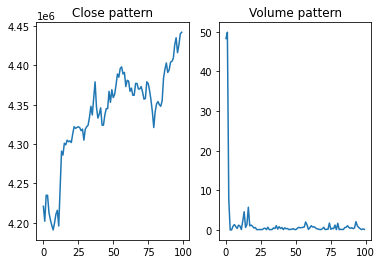

In [23]:
btc = pd.read_csv('btc_30min.csv')

#종가, 거래량 시각화해보기
close = btc['close']
volume = btc['volume']

#100캔들 단위 시계열 차트(기준이 될 패턴)
fig, ax = plt.subplots(1,2)
ax[0].plot(close[:100])
ax[1].plot(volume[:100])
ax[0].set_title('Close pattern')
ax[1].set_title('Volume pattern');

In [3]:
#정규화
base = btc.iloc[:100, [3,4]]

scaler = StandardScaler()

scaled_base = scaler.fit_transform(base)
scaled_base = pd.DataFrame(scaled_base, columns=['scaled_close', 'scaled_volume'])

scaled_base

,scaled_close,scaled_volume
0,-2.207432,-1.981868
1,-2.076252,-2.301932
2,-1.928675,-1.746032
3,-1.485942,-1.746032
4,-1.846687,-2.116632
...,...,...
95,1.629584,1.623060
96,1.465609,1.302996
97,1.465609,1.471451
98,1.662379,1.707287


In [4]:
#몇 개의 캔들을 예측을 위한 데이터로 사용할지 
window_size = len(scaled_base)    #100

#예측 기간 : (미래)몇 개의 캔들을 예측할지
next = 10

#window가 슬라이딩 할 횟수
moving_count = len(close) - window_size - (next + 1)
moving_count

82810

In [5]:
#1에 가까울수록 유사도가 높음
def cosine_similarity(x, y):
    return np.dot(x, y) / (np.sqrt(np.dot(x, x)) * np.sqrt(np.dot(y, y)))

In [6]:
#유사도를 저장하는 list
sim_list = []

for i in range(moving_count):
    target = btc.iloc[i:i+window_size, [3,4]]   #(100,2)
    
    #정규화
    scaled_target = scaler.fit_transform(target)
    scaled_target = pd.DataFrame(scaled_target, columns=['scaled_close', 'scaled_volume'])
    
    #종가, 거래량의 코사인 유사도 평균을 list에 저장
    cos_sim_close = cosine_similarity(scaled_base['scaled_close'], scaled_target['scaled_close'])
    cos_sim_volume = cosine_similarity(scaled_base['scaled_volume'], scaled_target['scaled_volume'])
    
    cos_sim = (cos_sim_close + cos_sim_volume) / 2
    
    sim_list.append(cos_sim)
    
#유사도 순서대로 index 확인
pd.Series(sim_list).sort_values(ascending=False).head(10)

0        1.000000
1        0.965519
2        0.938622
79777    0.937395
79776    0.935317
78726    0.935019
25152    0.934641
25153    0.933460
25151    0.932950
78727    0.931128
dtype: float64

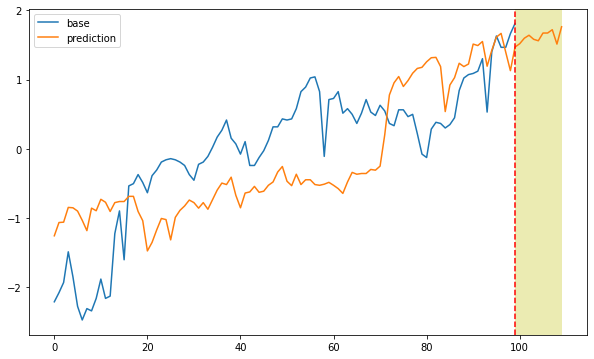

In [9]:
# 특정 시점과 가장 유사도가 높은 과거데이터 확인해보기
idx = 10000

top_ = btc.iloc[idx:(idx + window_size + next), [3,4]]
top_norm = scaler.fit_transform(top_)
top_norm = pd.DataFrame(top_norm, columns=['scaled_close', 'scaled_volume'])

plt.figure(figsize=(10,6))
plt.plot(scaled_base['scaled_close'].values, label='base')
plt.plot(top_norm['scaled_close'].values, label='prediction')
plt.axvline(x=len(scaled_base)-1, c='r', linestyle='--')  #현재/미래 경계선
plt.axvspan(len(scaled_base.values)-1, len(top_norm.values)-1, facecolor='y', alpha=0.3)
plt.legend();

In [13]:
#클래스로 만들어보기
class PatternFinder():
    def __init__(self, period=14):
        self.period = period
        
    def set_coin(self, coin:str, interval:str):
        self.coin = coin
        self.data = pyupbit.get_ohlcv(coin, count=2*60*24*365*5, interval=interval)
        self.close = self.data['close']
        self.volume = self.data['volume']
        return self.data
    
    def search(self, start:int, end:int, threshold=0.85):
        base = self.close.iloc[start:end, [3,4]]
        self.base_norm = (base - base.min()) / (base.max() - base.min())
        self.base = base
        
        display(base)
        
        window_size = len(base)
        moving_count = len(self.data) - window_size - (self.period + 1)    
        cos_sim = self.__cosine_sims(moving_count, window_size)
        
        self.window_size = window_size
        cos_sim = cos_sim[cos_sim > threshold]
        return cos_sim
        
    def __cosine_sims(self, moving_count, window_size):
        def cosine_similarity(x,y):
            return np.dot(x,y) / (np.sqrt(np.dot(x,x)) * (np.sqrt(np.dot(y,y))))
        
        sim_list = []
        
        for i in range(moving_count):
            target = self.close[i:(i + window_size)]
            
            target_norm = (target - target.min()) / (target.max() - target.min())
            
            cos_sim = cosine_similarity(self.base_norm, target_norm)
            
            sim_list.append(cos_sim)
        return pd.Series(sim_list).sort_values(ascending=False)
            
    def plot_pattern(self, idx, period=14):
        if period != self.period:
            self.period = period
            
        top = self.close[idx:(idx + self.window_size + period)]
        top_norm = (top - top.min()) / (top.max() - top.min())
        
        plt.plot(self.base_norm.values, label = 'base')
        plt.plot(top_norm.values, label='prediction')
        plt.axvline(x=len(self.base_norm)-1, c='r', linestyle='--')
        plt.axvspan(len(self.base_norm.values)-1, len(top_norm.values)-1,
                    facecolor='y', alpha=0.3)
        plt.legend();
        
        pred = self.change[(idx + self.window_size):(idx + self.window_size + period)]
        display(pred)
        print(f'pred : {pred.mean() * 100}%')
        
    def stat_prediction(self, result, period=14):
        idx_list = list(result.kes())
        mean_list = []
        for i in idx_list:
            pred = self.change[(idx + self.window_size):(idx + self.window_size + period)]
            mean_list.append(pred.mean())
        return np.array(mean_list)

In [24]:
pf = PatternFinder()

#pf.set_coin('BTC/KRW', 'minute30')

#pf.search('2022-01-01', '2022-01-09')

#pf.plot_pattern(0)